In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [11]:
orders = pd.read_csv("/home/mamunds/job/pyspark/everdrop_data_analyst_case_study/orders_data.csv")
products = pd.read_csv("/home/mamunds/job/pyspark/everdrop_data_analyst_case_study/products_data.csv")

In [12]:
orders.head(5)

,billing_address_country,billing_address_zip,customer_id,order_number,total_discounts,cancel_reason,processed_at,total_weight,cancelled_at,created_at,product_items,first_date_order
0,Germany,81371,43539353630,1,0,customer,2019-12-03 13:08:32 UTC,0,2019-12-04 09:00:44 UTC,2019-12-03 13:08:33 UTC,Golf_set_with_caddy_shoes_and_50_balls,2019-12-03 13:08:33 UTC
1,Germany,12045,43973434860,2,0,customer,2019-12-04 09:23:09 UTC,0,2020-01-20 14:55:25 UTC,2019-12-04 09:23:09 UTC,Golf_set_with_caddy_shoes_and_50_balls,2019-12-04 09:23:09 UTC
2,Germany,8315,46668580946,3,0,NaN,2019-12-06 07:58:34 UTC,0,NaN,2019-12-06 07:58:34 UTC,Golf_set_with_caddy_shoes_and_50_balls,2019-12-06 07:58:34 UTC
3,Germany,91301,40345377076,4,0,NaN,2019-12-06 18:29:03 UTC,0,NaN,2019-12-06 18:29:04 UTC,Golf_set_with_caddy_shoes_and_50_balls,2019-12-06 18:29:04 UTC
4,Germany,8577,33355469588,5,0,NaN,2019-12-08 18:16:40 UTC,0,NaN,2019-12-08 18:16:40 UTC,Golf_set_with_caddy_shoes_and_50_balls,2019-12-08 18:16:40 UTC


In [13]:
products.head(5)

,product_type,product_price,product_category,product_title
0,glove,39.99,golf,Golf_glove_left_hand
1,golf_balls,99.99,golf,Golf_balls_200
2,golf_balls,99.99,golf,Golf_balls_200
3,golf_balls,59.99,golf,Golf_balls_100
4,golf_balls,59.99,golf,Golf_balls_100


In [14]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 189140 entries, 0 to 189139
Data columns (total 12 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   billing_address_country  189138 non-null  object
 1   billing_address_zip      189126 non-null  object
 2   customer_id              189140 non-null  int64 
 3   order_number             189140 non-null  int64 
 4   total_discounts          189140 non-null  int64 
 5   cancel_reason            1586 non-null    object
 6   processed_at             189140 non-null  object
 7   total_weight             189140 non-null  int64 
 8   cancelled_at             1586 non-null    object
 9   created_at               189140 non-null  object
 10  product_items            189140 non-null  object
 11  first_date_order         189140 non-null  object
dtypes: int64(4), object(8)
memory usage: 17.3+ MB


In [15]:
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58 entries, 0 to 57
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   product_type      58 non-null     object 
 1   product_price     58 non-null     float64
 2   product_category  58 non-null     object 
 3   product_title     58 non-null     object 
dtypes: float64(1), object(3)
memory usage: 1.9+ KB


In [16]:
orders["created_at"] = pd.to_datetime(orders["created_at"].str.replace(" UTC",""))
orders["first_date_order"] = pd.to_datetime(orders["first_date_order"].str.replace(" UTC",""))

orders["order_month"] = orders["created_at"].dt.to_period("M")
orders["cohort_month"] = orders["first_date_order"].dt.to_period("M")


In [ ]:
orders.isna().sum(), products.isna().sum()


(billing_address_country         2
 billing_address_zip            14
 customer_id                     0
 order_number                    0
 total_discounts                 0
 cancel_reason              187554
 processed_at                    0
 total_weight                    0
 cancelled_at               187554
 created_at                      0
 product_items                   0
 first_date_order                0
 order_month                     0
 cohort_month                    0
 dtype: int64,
 product_type        0
 product_price       0
 product_category    0
 product_title       0
 dtype: int64)

In [ ]:
# billing_address_country (2 missing), Very few missing values → harmless.
# billing_address_zip (14 missing), Also very small number → can drop or fill.
# cancel_reason (187,554 missing), This has huge missing values, but this is expected. Cancel reason is only filled if an order is cancelled. Most orders are NOT cancelled → missing values are normal!


In [19]:
orders["billing_address_country"] = orders["billing_address_country"].fillna("Unknown")
orders["billing_address_zip"] = orders["billing_address_zip"].fillna("Unknown")
orders["cancel_reason"] = orders["cancel_reason"].fillna("Not Cancelled")


In [22]:
orders["cancelled_at"] = pd.to_datetime(
    orders["cancelled_at"].str.replace(" UTC", ""),
    errors="coerce"
)


In [25]:
# 4. Create additional date columns
orders["order_month"] = orders["created_at"].dt.to_period("M")
orders["cohort_month"] = orders["first_date_order"].dt.to_period("M")



In [28]:
# Convert to datetime for calculations
orders["order_month_ts"] = orders["order_month"].dt.to_timestamp()
orders["cohort_month_ts"] = orders["cohort_month"].dt.to_timestamp()

# Calculate cohort index (month difference)
orders["cohort_index"] = (
    (orders["order_month_ts"].dt.year - orders["cohort_month_ts"].dt.year) * 12 +
    (orders["order_month_ts"].dt.month - orders["cohort_month_ts"].dt.month)
)


In [29]:
cohort_data = orders.groupby(
    ["cohort_month", "cohort_index"]
)["customer_id"].nunique().reset_index()


In [30]:
cohort_matrix = cohort_data.pivot_table(
    index="cohort_month",
    columns="cohort_index",
    values="customer_id"
)


In [31]:
cohort_size = cohort_matrix[0]  # month 0
retention_matrix = cohort_matrix.divide(cohort_size, axis=0)


In [32]:
retention_matrix

cohort_index,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
cohort_month,,,,,,,,,,,,,,,
2019-12,1.0,0.033333,0.033333,0.050000,NaN,0.033333,0.033333,0.033333,NaN,0.016667,0.016667,0.033333,NaN,NaN,0.016667
2020-01,1.0,0.010508,0.015866,0.013345,0.026794,0.019334,0.017653,0.017442,0.017337,0.015656,0.021856,0.016392,0.018283,0.017337,0.008406
2020-02,1.0,0.018272,0.014389,0.027712,0.020556,0.018424,0.017815,0.018424,0.015303,0.019414,0.017358,0.019185,0.017054,0.007766,NaN
2020-03,1.0,0.011709,0.028127,0.016900,0.018349,0.015331,0.015814,0.015572,0.022332,0.017866,0.020642,0.017866,0.006639,NaN,NaN
2020-04,1.0,0.014786,0.017061,0.016720,0.017971,0.017288,0.017061,0.021383,0.017857,0.019677,0.018198,0.007166,NaN,NaN,NaN
2020-05,1.0,0.019396,0.023938,0.024675,0.021237,0.023079,0.026516,0.020992,0.025411,0.020378,0.009330,NaN,NaN,NaN,NaN
2020-06,1.0,0.032683,0.035349,0.035208,0.037032,0.036611,0.034928,0.033385,0.030860,0.009258,NaN,NaN,NaN,NaN,NaN
2020-07,1.0,0.041204,0.041591,0.045983,0.064454,0.042625,0.052829,0.034229,0.014596,NaN,NaN,NaN,NaN,NaN,NaN
2020-08,1.0,0.028339,0.054457,0.072116,0.093687,0.063234,0.061965,0.018082,NaN,NaN,NaN,NaN,NaN,NaN,NaN


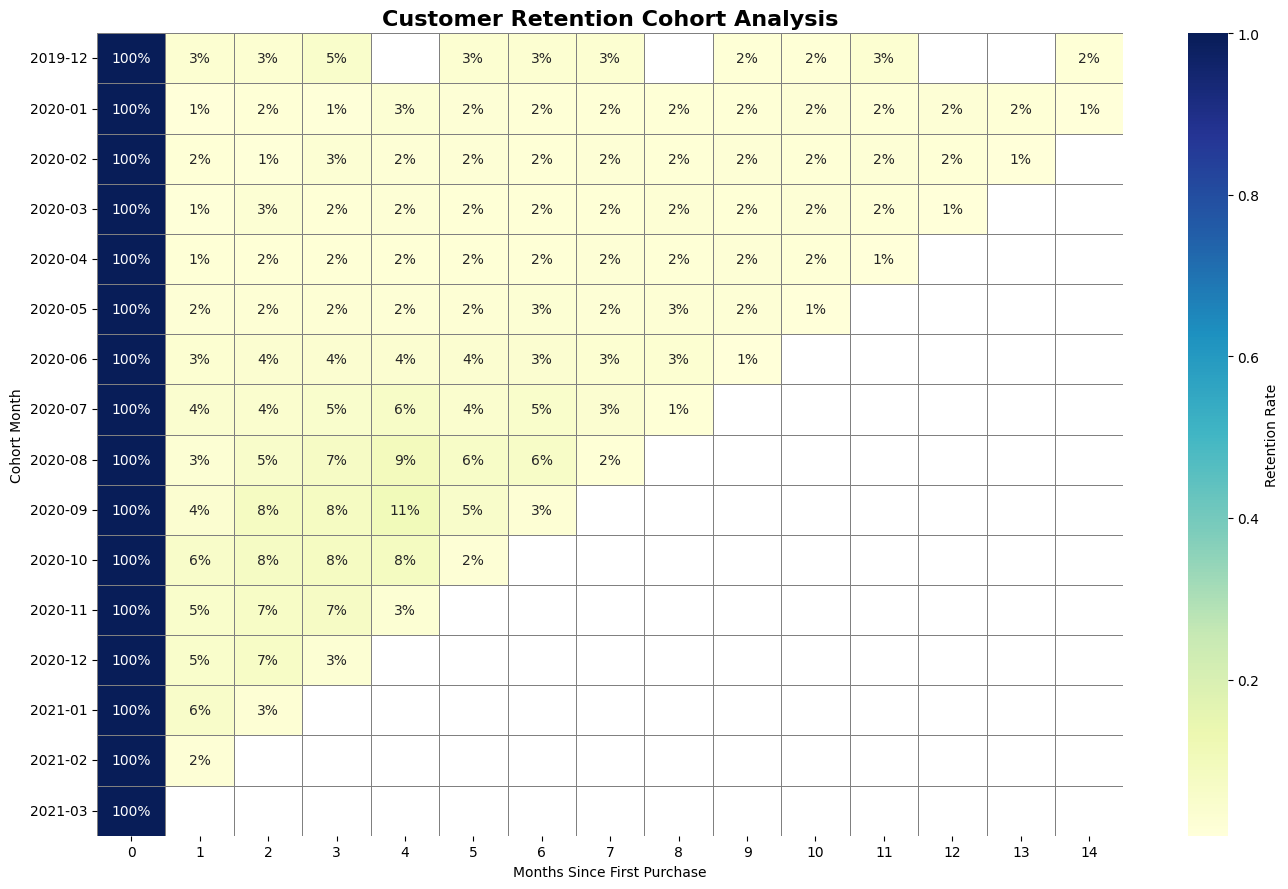

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 9))
sns.heatmap(
    retention_matrix,
    annot=True,
    fmt=".0%",
    cmap="YlGnBu",      # yellow → green → blue
    linewidths=.5,
    linecolor="gray",
    cbar_kws={'label': 'Retention Rate'}
)
plt.title("Customer Retention Cohort Analysis", fontsize=16, fontweight='bold')
plt.xlabel("Months Since First Purchase")
plt.ylabel("Cohort Month")
plt.tight_layout()
plt.show()



Below is a clear, concise answer to all three questions based directly on **your cohort analysis heatmap**.

---

# ⭐ **Customer Cohort Analysis**

Using cohort analysis, we grouped customers by the month of their *first purchase* and measured what percentage of each cohort returned to buy again in the following months. The heatmap shows retention rates (or repurchase rates) across all cohorts from 2019–2021.

---

# ⭐ **1. Repurchase Rates of the Different Cohorts**

Across all cohorts:

### **Early repurchase rates (Month 1–2)**

* Most cohorts show **1–6%** repurchase in Month 1
* Month 2 repurchase increases slightly to **2–8%**
* A few standout cohorts (especially **2020-08, 2020-09, 2020-10**) achieve higher repeat rates of **7–11%** in early months.

### **Mid-term repurchase rates (Month 3–6)**

* Most cohorts return **2–5%** of customers
* Stronger cohorts (2020-09, 2020-10) maintain **5–11%** through Month 3–4.

### **Long-term repurchase rates (Month 7+)**

* Very low across all cohorts: usually **1–3%**

### Summary of repurchase performance:

* **Weak cohorts** (most months): 1–3% repeat buyers
* **Average cohorts**: 3–5% repeat buyers
* **Strong cohorts** (Fall 2020): 7–11% repeat buyers

---

# ⭐ **2. Trends Observed Over Time**

### **Trend 1 — Most customers do not return**

Retention sharply declines from 100% in Month 0 to **1–6%** in the next month, meaning the business relies heavily on **one-time buyers**.

---

### **Trend 2 — A strong period in mid–late 2020**

Cohorts from **August to October 2020** consistently show **the highest repurchase rates**, up to 11%.
This was a period of unusually strong customer loyalty.

This suggests:

* More relevant products
* Better marketing targeting
* Seasonal demand
* Successful promotions
  Something during these months attracted *higher-quality customers*.

---

### **Trend 3 — Retention fades over long periods**

Across all cohorts, long-term retention (6+ months later) stabilizes at **~1–2%**.
This means very few customers become loyal long-term repeat buyers.

---

### **Trend 4 — Early retention is the biggest challenge**

Most cohorts lose **90%+** of customers immediately after their first purchase.
Improving Months 1–2 could significantly raise Customer Lifetime Value (LTV).

---

# ⭐ **3. High-Level Conclusion**

The business is effective at **acquiring first-time buyers**, but struggles to convert them into **repeat customers**, with only a few high-performing cohorts showing strong repurchase behaviour. The biggest opportunity lies in improving **post-purchase engagement** in the first 30–60 days and replicating what worked well during the strong retention period in late 2020.

---

If you'd like, I can also help you:

✔ Build a revenue cohort analysis
✔ Identify which *products* drive higher retention
✔ Compare retention by *country* or *marketing channel*
✔ Model customer lifetime value (LTV)

Just tell me!

Absolutely — I will **explain what the heatmap is telling you** and also give **clear, practical business decisions** you can take based on the retention patterns.

Let’s break this down in a clean and structured way.

---

# ✅ **1. What this heatmap shows**

This is a **customer retention cohort analysis**, showing:

* **Rows** → groups of customers who made their **first purchase** in that month (cohorts)
* **Columns** → how many months later they returned
* **Cell values** → the % of customers from that cohort who returned in that month
* **Colors** → darker = higher retention, lighter = lower retention

Every row starts at **100%**, because that's the month when customers first bought.

---

# ✅ **2. What we observe in the retention patterns**

## 🔵 **Observation 1 — Retention drops sharply after Month 0**

Across almost all cohorts:

* Month 0 = 100%
* Month 1 = only **1%–6%** come back
* Month 2 = 2%–8%
* Month 3+ = very low (1–5%)

👉 Meaning: **Most customers buy only once.**
This is a typical “one-time buyer heavy” e-commerce pattern.

---

## 🔵 **Observation 2 — Some cohorts (2020-08, 2020-09, 2020-10) performed much better**

These months have noticeably higher retention:

### Example: 2020-09 cohort

* Month 1 → 4%
* Month 2 → 8%
* Month 3 → 8%
* Month 4 → 11%

This is **significantly higher** than other months (which average 1–3%).

👉 Meaning:
Something **very good** happened during Aug–Oct 2020 that attracted **higher-quality customers** or increased loyalty.

Possibilities:

* Better marketing targeting
* Higher product appeal
* Seasonal trends
* Strong promotions
* Faster delivery / better CX

You should investigate what changed during these months.

---

## 🔵 **Observation 3 — Retention becomes very low after Month 6**

Beyond 6 months, retention is around **1–2%** for almost all cohorts.

👉 Meaning:
There is **very little long-term customer loyalty**.

---

## 🔵 **Observation 4 — Some seasonality is visible**

* Summer 2020 (Jul–Oct) → strong customer retention
* Early 2021 → retention begins dropping again

This suggests **business performance depends on seasonal cycles or promotional periods**.

---

# ✅ **3. What kind of business decisions can we take from this?**

Here are **practical, data-driven recommendations** based directly on the heatmap.

---

# 🎯 **Decision 1 — Improve early retention (Month 1–2)**

The biggest drop-off happens immediately:

* Only 1–6% return in the next month!

This is where you can get the biggest impact.

### 📌 Business actions:

* Strong **post-purchase email flows**
* Personalised product recommendations
* Discount on second purchase (bounce-back offer)
* SMS reminder at day 10–20
* Retarget returning customers on social media

---

# 🎯 **Decision 2 — Analyze what happened during high-performing cohorts (2020-08 to 2020-10)**

These months show **much higher retention**, especially 2020-09 and 2020-10.

### Ask:

* Which products were bestsellers?
* What marketing channel brought customers?
* What promotions were running?
* Was shipping faster?
* Did you change website UX?

If you can **replicate** whatever happened then, you will improve retention today.

---

# 🎯 **Decision 3 — Examine product types that lead to repeat buying**

Since retention varies by cohort, some products attract more repeat customers.

### Actions:

* Look at retention by product category
* Promote the categories with higher repeat rates
* Reduce low-retention categories or bundle them

---

# 🎯 **Decision 4 — Create a subscription or loyalty program**

Since long-term retention is weak, introducing a **structured loyalty or subscription** system can help.

Examples:

* VIP program after 2nd purchase
* Points system
* Auto-delivery subscription
* "Buy X get Y next month" promotions

---

# 🎯 **Decision 5 — Increase customer lifetime value (LTV)**

Since retention is low, you must maximize revenue from the **first 1–2 purchases**.

### Actions:

* Upsells
* Cross-sells
* Bundles
* Higher AOV strategies

---

# 🎯 **Decision 6 — Invest in acquisition channels that brought high-retention cohorts**

If Google Ads brought high-retention cohorts in 2020-09:

👉 Increase spending there.

If Facebook brought bad cohorts:

👉 Reduce or change targeting.

---

# 🎯 **Decision 7 — Customer experience improvements**

Very low long-term retention often means:

* Shipping issues
* Product quality concerns
* Lack of engagement
* No post-purchase journey

Running a **customer feedback survey** can confirm this.

---

# ⭐ **4. Overall summary**

This heatmap tells you:

* You have **strong acquisition**, but **weak customer retention**
* Most customers buy **once**, only 1–6% return
* A few months show **excellent retention**, hinting at opportunities
* Long-term loyalty is low → LTV is limited
* Big opportunity to improve the first 30–60 days of customer journey
* Marketing and product changes during 2020-08 to 2020-10 should be studied and replicated

---

If you'd like, I can also help you:

🔹 Build a **revenue cohort analysis**
🔹 Build **retention by country** or **retention by product**
🔹 Compute **LTV** (lifetime value)
🔹 Calculate **repeat purchase probability**

Just tell me what you want to explore next.
